## Lecture 2: Reliability



In [2]:
import os
import collections
import numpy as np
import pandas as pd
import seaborn
import json
from scipy import stats
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

## Reliability: Data as a model of itself

Here we will use data from the Self Regulation Ontology (SRO) project to assess reliability.  We will focus on one particular measure, the Barratt Impulsiveness Scale, which has a total of 30 items.

First we will look at 


In [20]:
SRO_datadir = 'data/SRO'

SRO_origdata = pd.read_csv(
    os.path.join(SRO_datadir, 'orig_subjects_x_items.csv'),
    index_col=0)
SRO_retestdata = pd.read_csv(
    os.path.join(SRO_datadir, 'retest_subjects_x_items.csv'),
    index_col=0)

# combine orig and retest data
SROdata = SRO_origdata.join(SRO_retestdata, lsuffix='_orig', rsuffix='_retest')

# extract BIS-11 attentional survey
BISdata = SROdata[[col for col in SROdata.columns if 'bis11_survey' in col]]
print(BISdata.shape)


(522, 60)


In [21]:
# compute total scores for each measure

BISdata['mean_test1'] = BISdata[[col for col in BISdata if '_orig' in col]].mean(1)
BISdata['mean_test2'] = BISdata[[col for col in BISdata if '_retest' in col]].mean(1)

BISdata_test_retest = BISdata.dropna()


Text(0,0.5,'BIS11 Overall - Retest score')

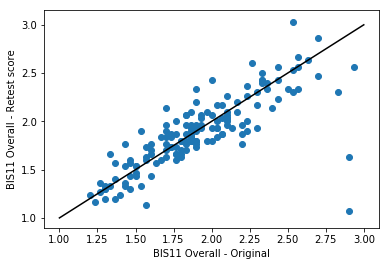

In [22]:
plt.scatter(BISdata_test_retest['mean_test1'], BISdata_test_retest['mean_test2'])
plt.plot([1, 3], [1, 3], color='black')
plt.xlabel('BIS11 Overall - Original')
plt.ylabel('BIS11 Overall - Retest score')


In [23]:
retest_reliability = np.corrcoef(BISdata_test_retest['mean_test1'], BISdata_test_retest['mean_test2'])[0,1]
retest_reliability

0.7816743533365371

## Split-half reliability

In the previous case, we had two overall scores for each individual.  However, those two scores were based on responses over a set of 30 total items.  Another way to assess reliability would be to randomly split those items into half, and look at the correlation between the two splits.

First let's load the item-level data for all subjects in the original SRO dataset:


In [26]:

BIS11_itemdata = SRO_origdata[[col for col in SRO_origdata.columns if 'bis11_survey' in col]].dropna()
BIS11_itemdata.shape

# replace item nums with item text

## first load item metadata
with open(os.path.join(SRO_datadir, 'bis11_survey.json')) as f:
    bis11_metadata = json.load(f)
# make metadata dict for column names
bis11_itemdict = {}
for i in bis11_metadata:
    if 'bis11' not in i:
        continue
    colname_split = i.split('survey_')
    colname = 'bis11_survey.%02.f' % (int(colname_split[1]))
    
    bis11_itemdict[colname] = bis11_metadata[i]['Description']

BIS11_itemdata = BIS11_itemdata.rename(columns=bis11_itemdict)

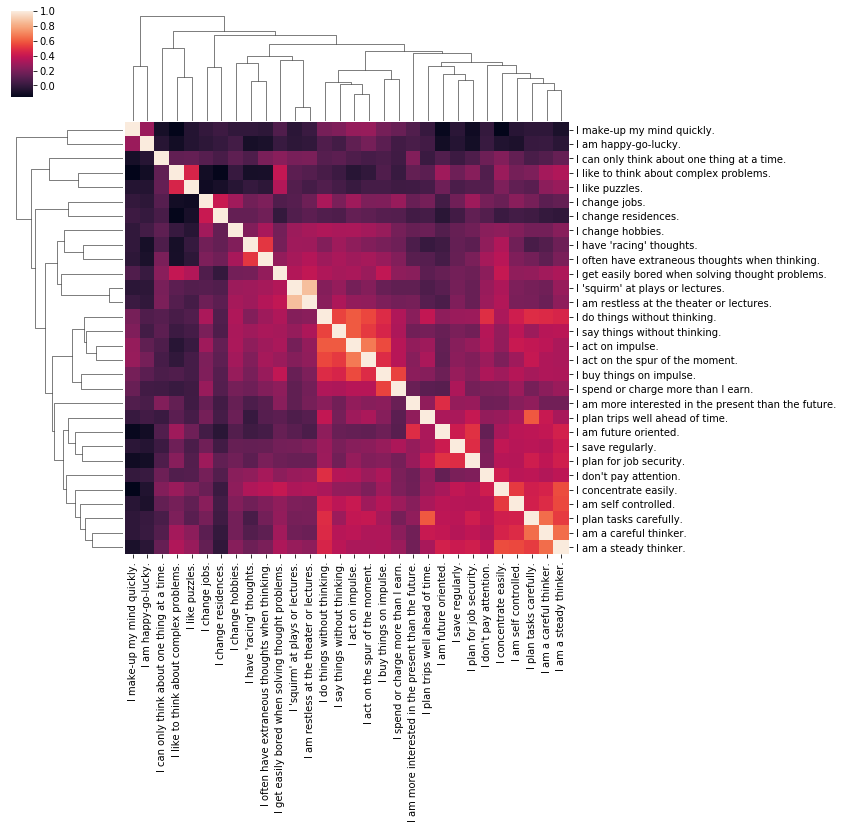

In [27]:
# Compute the correlation matrix across pairs items
cc = BIS11_itemdata.corr()

# display a cluster map

seaborn.clustermap(cc, )

Let's look at the split-half reliability of these items.  The basic idea is as follows:

- split the data into two sets of a particular size (randomly)
- assess the correlation between the splits


In [28]:
#here's a very simple implementation of split-half reliability
#this is a NON-boostrapping version

def get_correlation(data_by_trial, num_trials=None, num_splits=1000, random_seed=0):
    """arguments:
          data_by_trial -- (numpy array) the data
             assumes a tensor with structure is (observation units, trials)
             - e.g. (subjects, trials), or (items, trials)
             
          num_trials -- (nonnegative integer) how many trials to consider
          
          num_splits (nonnegative integer) how many splits of the data to make
          
       returns:
          array of length num_splits
    """

    # if it's a pandas data frame then convert to numpy array
    if isinstance(data_by_trial, pd.DataFrame):
        data_by_trial = data_by_trial.values

    #get total number of trials
    num_total_trials = data_by_trial.shape[1]
    
    if num_trials is None:
        num_trials = num_total_trials

    #you better not ask for more trials than you actually have
    assert num_trials <= num_total_trials,\
        "You asked for %d trials but there's only %d" % (num_trials, num_total_trials)
    
    #we want to make sure that while we select groups of trials basically randomly,
    #that we can still exactly reproduce our results later
    #so to do this, we use a constructed random number generator to select trial groups
    #and seed the generator with seed = 0 (could be any non-negative integer, but the seed
    #*must* be set for this to be reproducible
    random_number_generator = np.random.RandomState(seed=random_seed)

    corrvals = []
    for split_index in range(num_splits):
        #construct a new permutation of the trial indices
        perm =  random_number_generator.permutation(num_total_trials)
    
        #take the first num_trials/2 and second num_trials/2 pieces of the data
        first_half_of_trial_indices = perm[:int(num_trials / 2)]
        second_half_of_trial_indices = perm[int(num_trials / 2): num_trials]
        
        #mean over trial dimension
        mean_first_half_of_trials = data_by_trial[
            :, first_half_of_trial_indices].mean(axis=1)

        mean_second_half_of_trials = data_by_trial[
            :, second_half_of_trial_indices].mean(axis=1)
        
        #compute the correlation between the means
        corrval = stats.pearsonr(mean_first_half_of_trials, 
                                 mean_second_half_of_trials)[0]
        #add to the list
        corrvals.append(corrval)
        
    return np.array(corrvals)

In [29]:
corrvals = get_correlation(BIS11_itemdata)
np.mean(corrvals)

0.7943460948445455

Here we are using all of the items, but we can also see what happens when we only use a subset of items. 

In [30]:
split_half_by_num_trials = pd.DataFrame(
    {'ntrials': [i for i in range(4, 31, 2)]})


for idx in split_half_by_num_trials.index:
    corrs = get_correlation(BIS11_itemdata,
                            split_half_by_num_trials.loc[idx, 'ntrials'])
    split_half_by_num_trials.loc[idx, 'meancorr'] = np.mean(corrs)
    

Text(0,0.5,'Reliability')

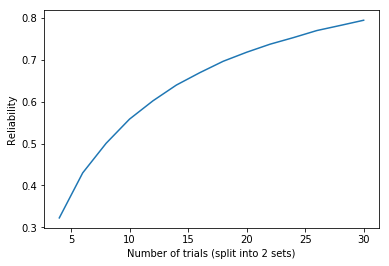

In [31]:
plt.plot(split_half_by_num_trials.ntrials, split_half_by_num_trials.meancorr)
plt.xlabel('Number of trials (split into 2 sets)')
plt.ylabel('Reliability')


This relation between the number of measurements and the split-half reliability follows a lawful relationship, known as the *Spearman-Brown prophecy* formula:

$$
\rho_k = \frac{k * \rho}{1 + (k-1)*\rho}
$$

where $\rho$ is the reliability obtained for a particular number of trials $t$, and $k$ is the multiple of $t$ for which you wish to determine the estimated reliability.

Here let's take the reliability estimated for a total of 4 items, and use it to extrapolate the reliability for larger item sets.


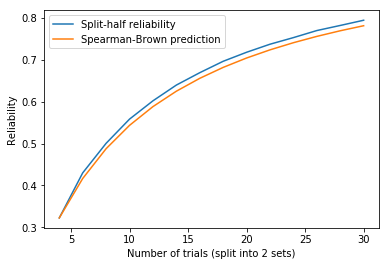

In [32]:
def spearman_brown(rho, k):
    return((k*rho)/(1 + (k-1)*rho))

rho = split_half_by_num_trials['meancorr'].iloc[0]

for idx in split_half_by_num_trials.index:
    k = split_half_by_num_trials.loc[idx, 'ntrials']/4
    split_half_by_num_trials.loc[idx, 'sb'] = spearman_brown(rho, k)
    
plt.plot(split_half_by_num_trials.ntrials, split_half_by_num_trials.meancorr)
plt.plot(split_half_by_num_trials.ntrials, split_half_by_num_trials.sb)
plt.xlabel('Number of trials (split into 2 sets)')
plt.ylabel('Reliability')
plt.legend(['Split-half reliability', 'Spearman-Brown prediction'])

## Reliability in psychometrics


Here is a path diagram - to see the code that generated it, look at PathDiagramExample.Rmd in this directory.


![title](path_diagram.png)

Generate some data from this model. We will treat the latent variables as normally distributed, with some degree of correlation.

In [3]:
def make_data(n_subjects=500,
              corr=0.5,
              error_var=0.5,
              scale_data=True,
              latent_seed=None,
              betavals=None):
    """
    create observed measurements from latent variables
    
    Parameters:
    ------------
    n_subjects: number of observations
    corr: population correlation between latent variables
    error_var: error variance
    scale_data: should we scale the variables?
    latent_seed: if set, will generate the same latent values each time (with different noise)
    """
    
    # create latent variables - multivariate normal with specified correlation

    if latent_seed is not None:
        np.random.seed(12345)
    latents = np.random.multivariate_normal(mean=[0, 0], 
                                            cov=[[1, corr], [corr, 1]],
                                            size=n_subjects)
    if scale_data:
        latents = scale(latents)

    df = pd.DataFrame(latents, columns=['impulsivity', 'impatience'])

    # create matrix to project latents into observed

    beta = pd.DataFrame(np.zeros((2, 4)), 
                        columns=['BIS', 'UPPS-P', 'Kirby', 'Bickel'],
                        index=df.columns)
    if betavals is None:
        betavals = {('impulsivity', 'BIS'): 1,
                    ('impulsivity', 'UPPS-P'): 1,
                    ('impatience', 'Bickel'): 1,
                    ('impatience', 'Kirby'): 1}
    for b in betavals:
        beta.loc[b[0], b[1]] = betavals[b]

    # create measurement noise, assume all variables have equal noise
    np.random.seed()  # ensure different noise each time
    measurement_noise = np.random.multivariate_normal(
        mean=[0, 0, 0, 0], 
        cov=np.eye(4)*error_var,
        size=n_subjects)

    # create observed data
    observed = df.dot(beta) + measurement_noise

    if scale_data:
        observed = (observed - observed.mean(axis=0))/observed.std(axis=0)

    df = result = pd.concat([df, observed], axis=1)

    return(df)

In [4]:
df = make_data(latent_seed=123345)
df.head()

,impulsivity,impatience,BIS,UPPS-P,Kirby,Bickel
0,-0.077887,0.377001,-0.161044,-0.055764,0.605267,0.956276
1,0.720615,0.129221,0.990508,0.751484,0.538181,0.547651
2,-2.440260,-1.062950,-1.320668,-1.452865,0.580210,-0.816762
3,-0.238764,0.016280,-1.031713,-0.031735,-0.394431,0.437345
4,-1.318268,-0.088177,-0.822948,-0.872747,-0.533547,-0.427754


Let's plot a heatmap of the correlations between latent and observed values

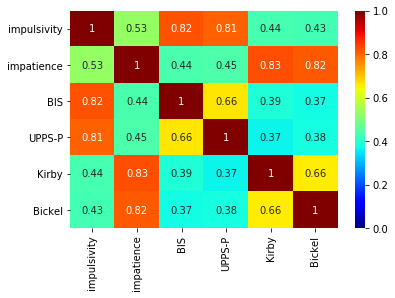

In [5]:
seaborn.heatmap(df.corr(), annot=True, vmin=0, cmap='jet')

What is the reliability of the measures for each latent?

In [6]:
rho_impulsivity = df[['BIS', 'UPPS-P']].corr().iloc[0, 1]
print('Impulsivity:', rho_impulsivity)

rho_impatience = df[['Kirby', 'Bickel']].corr().iloc[0, 1]
print('Impatience:', rho_impatience)

Impulsivity: 0.6648867705009279
Impatience: 0.6584533645365909


## Attenuation

Error variance in our measures will *attenuate* the correlation between measures.  In this example, let's say that we wanted to estimate the correlation between impulsivity and impatience using the BIS and Kirby measures.  In this case, we know the true correlations of the latent variables:

In [7]:
rho_impulsivity_impatience = df[['impulsivity', 'impatience']].corr().iloc[0,1]
rho_impulsivity_impatience

0.5289766901235785

What do we see when we compare the two (noisy) measures?


In [8]:
rho_BIS_Kirby = df[['BIS', 'Kirby']].corr().iloc[0,1]
rho_BIS_Kirby

0.3870255717509105

We see here that the correlation between the measures is smaller than the correlation between their true scores.  We can correct for this attenuation using Spearman's formula:

$$
\rho_{T_Y, T_{Y'}} = \frac{\rho_{Y, Y'}}{\sqrt{\rho_Y \rho_{Y'}}}
$$

That is, the observed correlation is attenuated by the square root of the product of the reliabilities of the individual variables. We can see this with our measures:

In [9]:
rho_BIS_Kirby_corrected = rho_BIS_Kirby/np.sqrt(rho_impatience*rho_impulsivity)
rho_BIS_Kirby_corrected

0.5849292031337798

We see that this is much closer to the true correlation between the latent variables.

- make point that observed correlation is limited by reliability - talk about voodoo correlations example

## Test-retest reliability

Let's compare this what we see if we were to collect a new dataset with the same latent variables but different noise:


In [10]:
df_retest = make_data(latent_seed=123345)

retest_correlations = pd.Series(index=['BIS', 'UPPS-P', 'Kirby', 'Bickel'], 
                                dtype=float)

for i in retest_correlations.index:
    retest_correlations[i] = np.corrcoef(df[i], df_retest[i])[0,1]

retest_correlations

BIS       0.672881
UPPS-P    0.664496
Kirby     0.669825
Bickel    0.684518
dtype: float64

These are very close to the reliabilities that we estimated above by comparing the two tests - unsurprisingly, since all of these were generated by simply adding the same kind of noise to the latents. 

In the former case we used Pearson correlation to compute the reliability.  The Pearson coefficient assesses the degree to which the variables are linearly related, but doesn't penalize for different means or slope other than one.  That it, it assesses how well the following model describes the data:

$$
y = slope * X + intercept
$$

In other cases, we might want to hold our measurements to a higher standard of consistency or agreement. The *intraclass correlation coefficient* is commonly used for this purpose. There are many different forms of the ICC - here we will focus on ICC(3,1), which is commonly used to assess retest reliability:

$$
ICC(3,1) = \frac{MS_{subjects} - MS_{error}}{MS_{subjects} + MS_{error}}
$$

for the specific version with two measurements for each subject.  

In [11]:
# adapted from https://github.com/nipy/nipype/blob/f2bbcc917899c98102bdeb84db61ea4b84cbf2f5/nipype/algorithms/icc.py#L29

def ICC_rep_anova(Y, verbose=True):
    '''
    the data Y are entered as a 'table' ie subjects are in rows and repeated
    measures in columns
    One Sample Repeated measure ANOVA
    Y = XB + E with X = [FaTor / Subjects]
    '''

    [nb_subjects, nb_conditions] = Y.shape
    dfc = nb_conditions - 1
    dfe = (nb_subjects - 1) * dfc
    dfr = nb_subjects - 1

    # Compute the repeated measure effect
    # ------------------------------------

    # Sum Square Total
    mean_Y = np.mean(Y)
    SST = ((Y - mean_Y)**2).sum()

    # create the design matrix for the different levels
    x = np.kron(np.eye(nb_conditions), np.ones((nb_subjects, 1)))  # sessions
    x0 = np.tile(np.eye(nb_subjects), (nb_conditions, 1))  # subjects
    X = np.hstack([x, x0])

    # Sum Square Error
    predicted_Y = np.dot(np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))), X.T), Y.flatten('F'))
    residuals = Y.flatten('F') - predicted_Y
    SSE = (residuals**2).sum()

    residuals.shape = Y.shape

    MSE = SSE / dfe

    # Sum square session effect - between colums/sessions
    SSC = ((np.mean(Y, 0) - mean_Y)**2).sum() * nb_subjects
    MSC = SSC / dfc / nb_subjects

    session_effect_F = MSC / MSE

    # Sum Square subject effect - between rows/subjects
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    # ICC(3,1) = (mean square subjeT - mean square error) /
    #            (mean square subjeT + (k-1)*-mean square error)
    ICC = (MSR - MSE) / (MSR + dfc * MSE)

    e_var = MSE  # variance of error
    r_var = (MSR - MSE) / nb_conditions  # variance between subjects
    if verbose:
        print('ICC:', ICC)
        print('r:', np.corrcoef(Y.T)[0, 1])
    return ICC, r_var, e_var, session_effect_F, dfc, dfe

In [12]:
Y = pd.DataFrame({'orig':df['BIS'], 'retest': df_retest['BIS']})

_ = ICC_rep_anova(Y.values)

ICC: 0.6728805267214538
r: 0.6728805267214539


In this case we see that the ICC is exactly the same as the Pearson correlation, because the values have the same variance. However, because the ICC uses a pooled variance whereas the Pearson R scales separately by the variance of each variable, the ICC will differ if the variances differ:

In [13]:
Y['retest'] = Y['retest'] * 2

_ = ICC_rep_anova(Y.values)

ICC: 0.5383044213771633
r: 0.6728805267214539


TBD: need to clarify when to use what
- add to split half function as a different statfunc

## A real-world example

IT data


In [17]:
orig_data = pd.read_csv('data/digit_span/orig_digit_span.csv').query('condition=="forward"')
retest_data = pd.read_csv('data/digit_span/retest_digit_span.csv').query('condition=="forward"')

## Internal consistency

In cases where we don't have multiple parallel measures of the same underlying construct, another alternative is to assess the internal consistency of the individual measurements on our single measure.

Here let's look at 


## Split-half reliability

